In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import librosa
import librosa.display
from collections import Counter
from wordcloud import WordCloud
from tqdm import tqdm  # Thanh tiến trình
import warnings

# Tắt cảnh báo cho gọn
warnings.filterwarnings("ignore")

# Cấu hình hiển thị biểu đồ
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 12

print("✅ Đã import thư viện thành công!")


✅ Đã import thư viện thành công!


In [2]:
# --- CẤU HÌNH ĐƯỜNG DẪN (Relative Paths) ---
BASE_PATH = os.getcwd()  # Lấy thư mục hiện tại

# 1. TEXT PATHS (File CSV đã split)
TEXT_TRAIN_CSV = os.path.join(BASE_PATH, "processed_data/text/train_split.csv")
TEXT_VAL_CSV = os.path.join(BASE_PATH, "processed_data/text/eval_split.csv")
TEXT_TEST_CSV = os.path.join(BASE_PATH, "processed_data/text/test_split.csv")
TEXT_CSV = os.path.join(
    BASE_PATH, "processed_data/text/TRAINING_TEXT_DATA_FINAL_COMBINED.csv"
)

# 2. VIDEO PATHS (Raw Data Sources)
# Liệt kê các folder chứa video gốc
VIDEO_SOURCE_DIRS = [
    os.path.join(BASE_PATH, "data/videos"),
    os.path.join(BASE_PATH, "data_1/videos"),
    # Thêm data_viet hoặc các nguồn khác nếu có
]

# 3. AUDIO PATHS (Processed Wav Files)
AUDIO_DIR = os.path.join(BASE_PATH, "processed_data/audios")

print(f"📍 Base Path: {BASE_PATH}")
print(f"📍 Checking Text Train Path: {os.path.exists(TEXT_TRAIN_CSV)}")
print(f"📍 Checking Text Val Path: {os.path.exists(TEXT_VAL_CSV)}")
print(f"📍 Checking Text Test Path: {os.path.exists(TEXT_TEST_CSV)}")
print(f"📍 Checking Audio Dir: {os.path.exists(AUDIO_DIR)}")
print(f"📍 Video Source Dirs: {[os.path.exists(dir) for dir in VIDEO_SOURCE_DIRS]}")


📍 Base Path: /home/guest/Projects/SE363/UIT-SE363-Big-Data-Platform-Application-Development
📍 Checking Text Train Path: True
📍 Checking Text Val Path: True
📍 Checking Text Test Path: True
📍 Checking Audio Dir: True
📍 Video Source Dirs: [True, True]


# Load dữ liệu Text & Kiểm tra tổng quan

In [3]:
def load_all_text_data():
    dataframes = {}
    total_samples = 0

    splits = {
        "text": TEXT_CSV,
        "Train": TEXT_TRAIN_CSV,
        "Val": TEXT_VAL_CSV,
        "Test": TEXT_TEST_CSV,
    }

    for name, path in splits.items():
        if os.path.exists(path):
            df = pd.read_csv(path)
            # Đảm bảo format đúng
            df = df.dropna(subset=["text", "label"])
            df["label"] = df["label"].astype(int)
            df["text"] = df["text"].astype(str)

            dataframes[name] = df
            total_samples += len(df)
            print(f"✅ Loaded {name}: {len(df)} samples")
        else:
            print(f"❌ Missing {name} file at: {path}")

    return dataframes


dfs = load_all_text_data()

# Gộp toàn bộ để phân tích tổng thể (Distribution)
if dfs:
    df_full = pd.concat(dfs.values(), ignore_index=True)
    print(f"\n∑ Tổng số mẫu toàn bộ dataset: {len(df_full)}")
    display(df_full.head())


✅ Loaded text: 2430 samples
✅ Loaded Train: 840 samples
✅ Loaded Val: 107 samples
✅ Loaded Test: 105 samples

∑ Tổng số mẫu toàn bộ dataset: 3482


,video_id,path,filename,text,label,confidence
0,7522809443281669383,not_harmful/video_844/7522809443281669383.mp4,7522809443281669383.mp4,dream body . 髪型なんてオーダーしてるか知りたいです . cleaning my...,0,0.95
1,7516567349839858952,harmful/video_292/7516567349839858952.mp4,7516567349839858952.mp4,mình lấy lại được rồi . còn giữ hình ảnh hoá đ...,0,0.90
2,7559098335244684561,harmful/video_824/7559098335244684561.mp4,7559098335244684561.mp4,lỡ lộn người thì sao ạ . không nhịn được cừi k...,1,0.95
3,7480517394046209298,not_harmful/video_205/7480517394046209298.mp4,7480517394046209298.mp4,hahaha cutie monicaa . omg same im on my 3rd y...,0,0.90
4,7570735139882355976,harmful/video_750/7570735139882355976.mp4,7570735139882355976.mp4,mong e mang cho gia đình may mắn và mình nhé ....,0,0.97


# Phân tích Mất cân bằng dữ liệu (Class Imbalance) - QUAN TRỌNG

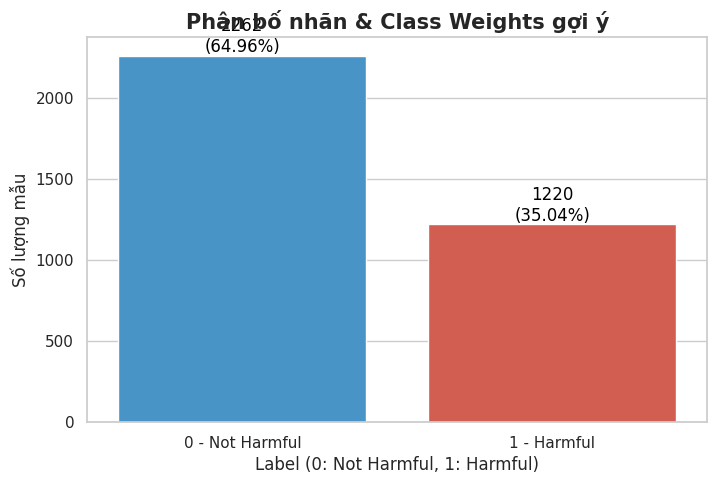

🚀 PHÂN TÍCH MẤT CÂN BẰNG DỮ LIỆU (CLASS IMBALANCE)
📊 Thống kê mẫu:
   - Label 0 (Not Harmful): 2262
   - Label 1 (Harmful):     1220
--------------------------------------------------
⚠️ Tỷ lệ chênh lệch (Imbalance Ratio): 1 : 1.85
--------------------------------------------------
⚖️  Class Weights chuẩn (Sklearn 'balanced'): [np.float64(0.7697), np.float64(1.427)]
--------------------------------------------------
👉 HÀNH ĐỘNG: Copy dòng dưới đây vào file 'text_configs.py':
"class_weights": [np.float64(0.7697), np.float64(1.427)],


In [4]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

if "df_full" in locals():
    # --- 1. VẼ BIỂU ĐỒ & HIỂN THỊ SỐ LIỆU ---
    label_counts = df_full["label"].value_counts().sort_index()
    total = len(df_full)

    plt.figure(figsize=(8, 5))
    ax = sns.countplot(x="label", data=df_full, palette=["#3498db", "#e74c3c"])
    plt.title("Phân bố nhãn & Class Weights gợi ý", fontsize=15, fontweight="bold")
    plt.xlabel("Label (0: Not Harmful, 1: Harmful)")
    plt.ylabel("Số lượng mẫu")
    plt.xticks([0, 1], ["0 - Not Harmful", "1 - Harmful"])

    # Annotation (Hiển thị số lượng & %)
    for p in ax.patches:
        count = int(p.get_height())
        percent = 100 * count / total
        ax.annotate(
            f"{count}\n({percent:.2f}%)",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="bottom",
            fontsize=12,
            color="black",
        )
    plt.show()

    # --- 2. TÍNH TOÁN CÁC CHỈ SỐ ---
    # a. Tính tỷ lệ đơn giản (Imbalance Ratio) để dễ hình dung
    # (Nếu Label 1 không tồn tại để tránh lỗi chia cho 0)
    count_0 = label_counts.get(0, 0)
    count_1 = label_counts.get(1, 0)
    ratio = count_0 / count_1 if count_1 > 0 else 0

    # b. Tính Class Weights chuẩn xác bằng Sklearn (Dùng cho Config)
    classes = np.unique(df_full["label"])
    weights = compute_class_weight(
        class_weight="balanced", classes=classes, y=df_full["label"]
    )
    weights_list = [round(w, 4) for w in weights]

    # --- 3. IN BÁO CÁO TỔNG HỢP ---
    print("=" * 50)
    print("🚀 PHÂN TÍCH MẤT CÂN BẰNG DỮ LIỆU (CLASS IMBALANCE)")
    print("=" * 50)
    print(f"📊 Thống kê mẫu:")
    print(f"   - Label 0 (Not Harmful): {count_0}")
    print(f"   - Label 1 (Harmful):     {count_1}")
    print("-" * 50)
    print(f"⚠️ Tỷ lệ chênh lệch (Imbalance Ratio): 1 : {ratio:.2f}")

    print("-" * 50)
    print(f"⚖️  Class Weights chuẩn (Sklearn 'balanced'): {weights_list}")
    print("-" * 50)
    print("👉 HÀNH ĐỘNG: Copy dòng dưới đây vào file 'text_configs.py':")
    print(f'"class_weights": {weights_list},')
    print("=" * 50)


# Phân tích độ dài văn bản (Text Length)

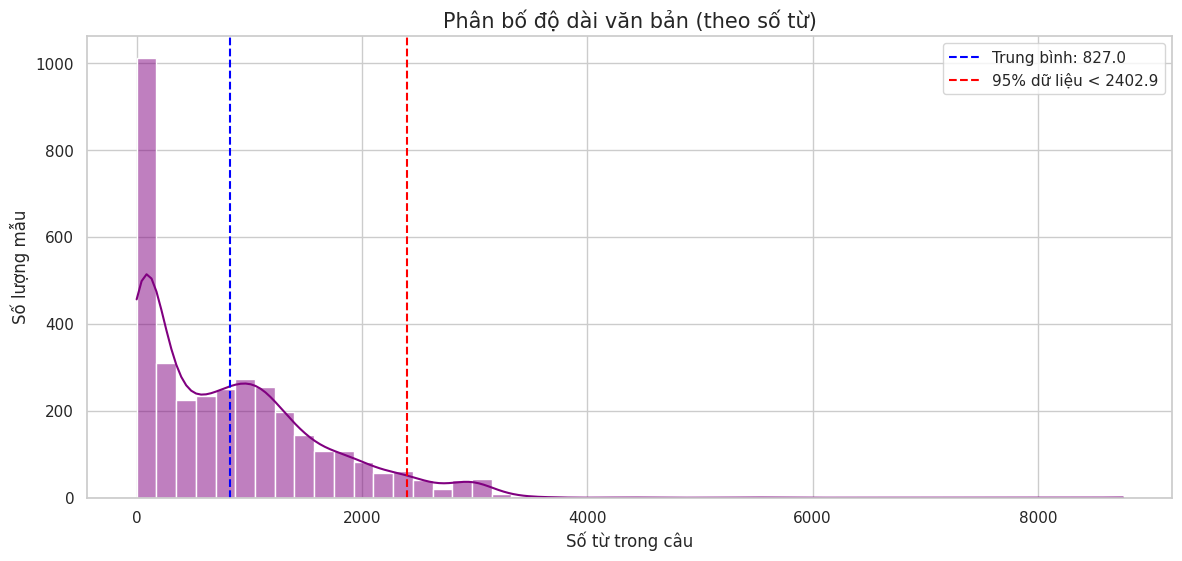

📏 Độ dài trung bình: 827.05 từ
📏 Độ dài lớn nhất: 8756 từ
💡 Gợi ý: Set max_text_len >= 2402 để bao phủ 95% dữ liệu.


In [5]:
if "df_full" in locals():
    # Tính số từ (Word count)
    df_full["word_count"] = df_full["text"].apply(lambda x: len(x.split()))

    # Tính thống kê
    mean_len = df_full["word_count"].mean()
    max_len = df_full["word_count"].max()
    p95_len = np.percentile(df_full["word_count"], 95)

    # Vẽ biểu đồ
    plt.figure(figsize=(14, 6))

    # Histogram
    sns.histplot(df_full["word_count"], bins=50, kde=True, color="purple")

    # Đường tham chiếu
    plt.axvline(
        mean_len, color="blue", linestyle="--", label=f"Trung bình: {mean_len:.1f}"
    )
    plt.axvline(
        p95_len, color="red", linestyle="--", label=f"95% dữ liệu < {p95_len:.1f}"
    )

    plt.title("Phân bố độ dài văn bản (theo số từ)", fontsize=15)
    plt.xlabel("Số từ trong câu")
    plt.ylabel("Số lượng mẫu")
    plt.legend()
    plt.show()

    print(f"📏 Độ dài trung bình: {mean_len:.2f} từ")
    print(f"📏 Độ dài lớn nhất: {max_len} từ")
    print(f"💡 Gợi ý: Set max_text_len >= {int(p95_len)} để bao phủ 95% dữ liệu.")


# Word Cloud (Từ khóa nổi bật theo nhãn)

☁️ Word Cloud - LABEL 1 (Harmful)


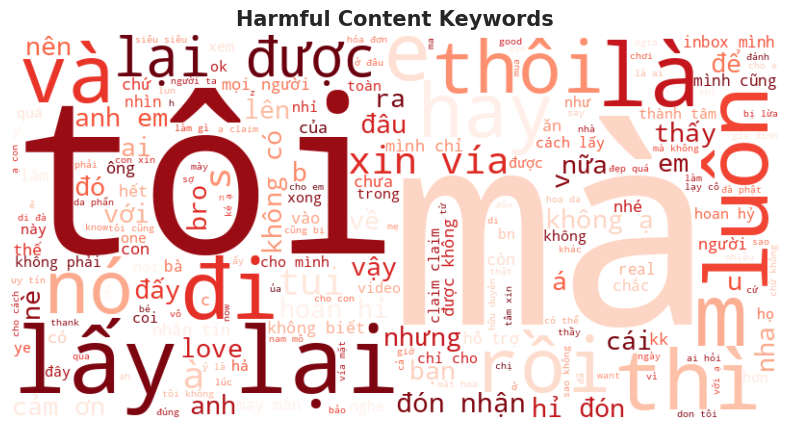

☁️ Word Cloud - LABEL 0 (Not Harmful)


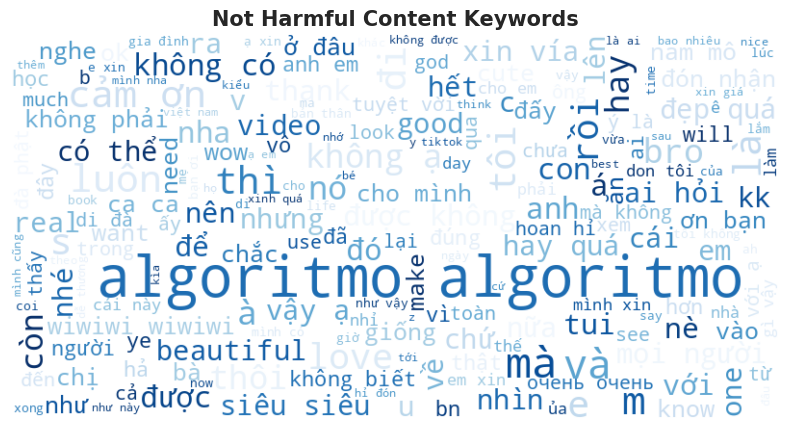

In [6]:
if "df_full" in locals():

    def plot_wordcloud(text_series, title, cmap="viridis"):
        text_combined = " ".join(text_series.astype(str))
        wordcloud = WordCloud(
            width=800, height=400, background_color="white", colormap=cmap
        ).generate(text_combined)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(title, fontsize=15, fontweight="bold")
        plt.show()

    print("☁️ Word Cloud - LABEL 1 (Harmful)")
    plot_wordcloud(
        df_full[df_full["label"] == 1]["text"], "Harmful Content Keywords", cmap="Reds"
    )

    print("☁️ Word Cloud - LABEL 0 (Not Harmful)")
    plot_wordcloud(
        df_full[df_full["label"] == 0]["text"],
        "Not Harmful Content Keywords",
        cmap="Blues",
    )


# Phân tích Video (Duration & Resolution)


🎥 Đang quét Video Metadata... (Lấy mẫu ngẫu nhiên)


Scanning videos:  70%|███████   | 352/500 [00:00<00:00, 445.66it/s][ WARN:0@5.699] global cap.cpp:175 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.12.0) /io/opencv/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


Scanning videos:  29%|██▉       | 144/500 [00:00<00:00, 472.34it/s][ WARN:0@6.425] global cap.cpp:175 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.12.0) /io/opencv/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'


Scanning videos: 100%|██████████| 500/500 [00:01<00:00, 488.15it/s]



🎬 THỐNG KÊ DỮ LIỆU VIDEO (SAMPLE)
∑ Số video đã quét: 998
----------------------------------------
⏱️ Thời lượng TB: 54.22 giây
----------------------------------------
🖥️ Top 5 Độ phân giải phổ biến:
res
1080x1920    418
720x1280     236
576x1024     119
1920x1080     17
1080x1080     13
----------------------------------------
🎞️ Top 5 FPS phổ biến:
fps
30    661
29     91
60     77
25     50
24     39


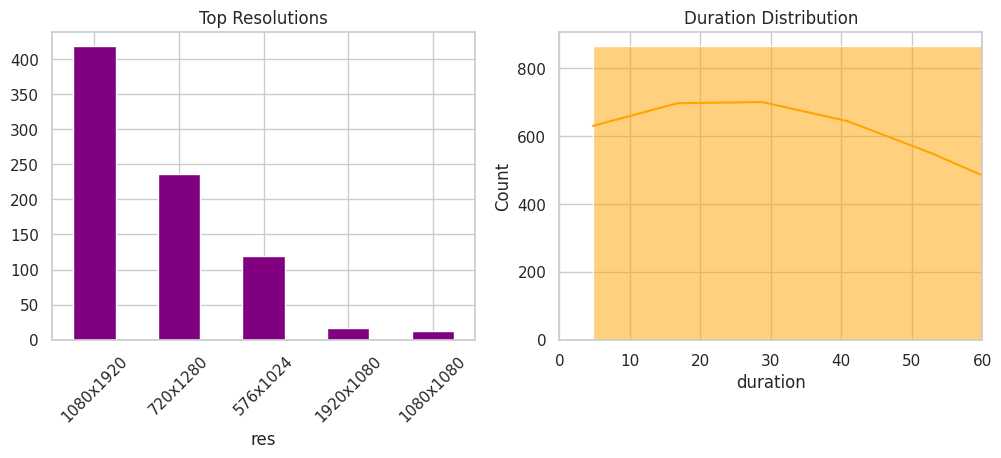

In [7]:
def analyze_video_statistics(source_dirs, limit_per_folder=500):
    print("\n🎥 Đang quét Video Metadata... (Lấy mẫu ngẫu nhiên)")
    stats = []
    exts = (".mp4", ".avi", ".mov", ".mkv")

    for folder in source_dirs:
        if not os.path.exists(folder):
            continue

        files = []
        for root, _, fs in os.walk(folder):
            for f in fs:
                if f.lower().endswith(exts):
                    files.append(os.path.join(root, f))

        # Lấy mẫu ngẫu nhiên để chạy cho nhanh
        if len(files) > limit_per_folder:
            files = np.random.choice(files, limit_per_folder, replace=False)

        for path in tqdm(files, desc=f"Scanning {os.path.basename(folder)}"):
            try:
                cap = cv2.VideoCapture(path)
                if cap.isOpened():
                    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                    fps = int(cap.get(cv2.CAP_PROP_FPS))
                    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                    duration = frame_count / fps if fps > 0 else 0

                    stats.append({"res": f"{w}x{h}", "fps": fps, "duration": duration})
                cap.release()
            except:
                pass

    if not stats:
        print("❌ Không quét được video nào.")
        return

    df = pd.DataFrame(stats)

    print("\n" + "=" * 40)
    print("🎬 THỐNG KÊ DỮ LIỆU VIDEO (SAMPLE)")
    print("=" * 40)
    print(f"∑ Số video đã quét: {len(df)}")
    print("-" * 40)
    print(f"⏱️ Thời lượng TB: {df['duration'].mean():.2f} giây")
    print("-" * 40)
    print("🖥️ Top 5 Độ phân giải phổ biến:")
    print(df["res"].value_counts().head(5).to_string())
    print("-" * 40)
    print("🎞️ Top 5 FPS phổ biến:")
    print(df["fps"].value_counts().head(5).to_string())
    print("=" * 40)

    # Biểu đồ
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    df["res"].value_counts().head(5).plot(kind="bar", color="purple")
    plt.title("Top Resolutions")
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    sns.histplot(df["duration"], bins=30, color="orange", kde=True)
    plt.title("Duration Distribution")
    plt.xlim(0, 60)
    plt.show()


analyze_video_statistics(VIDEO_SOURCE_DIRS)


# Phân tích Audio (Waveform & Duration)


🎧 Đang quét Audio... (Vui lòng đợi)


Scanning Audio: 100%|██████████| 1133/1133 [00:00<00:00, 2040.46it/s]



🎵 THỐNG KÊ DỮ LIỆU AUDIO
∑ Tổng số file: 1133
❌ File lỗi/0s:   1
----------------------------------------
⏱️ Tổng thời lượng: 16.87 giờ
⏱️ Trung bình/file: 53.60 giây
⏱️ Ngắn nhất:       0.00 giây
⏱️ Dài nhất:        3194.67 giây


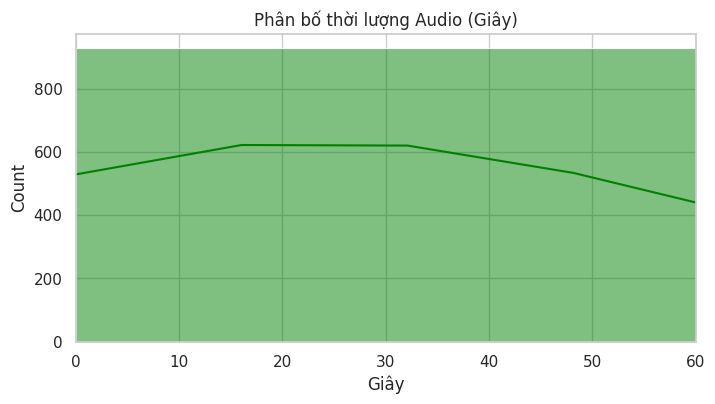

In [8]:
import os
import glob
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


def analyze_audio_statistics(audio_dir):
    print("\n🎧 Đang quét Audio... (Vui lòng đợi)")

    # [FIX] Sửa glob thành glob.glob
    wav_files = glob.glob(os.path.join(audio_dir, "*.wav"))

    if not wav_files:
        print(f"❌ Không tìm thấy file wav tại: {audio_dir}")
        return

    durations = []
    error_files = []

    for f in tqdm(wav_files, desc="Scanning Audio"):
        try:
            # Dùng librosa.get_duration nhanh hơn load full
            d = librosa.get_duration(path=f)
            durations.append(d)
            if d == 0:
                error_files.append(os.path.basename(f))
        except Exception:
            error_files.append(os.path.basename(f))

    if len(durations) == 0:
        print("❌ Không đọc được duration của file nào.")
        return

    durations = np.array(durations)

    print("\n" + "=" * 40)
    print("🎵 THỐNG KÊ DỮ LIỆU AUDIO")
    print("=" * 40)
    print(f"∑ Tổng số file: {len(durations)}")
    print(f"❌ File lỗi/0s:   {len(error_files)}")
    print("-" * 40)
    print(f"⏱️ Tổng thời lượng: {np.sum(durations)/3600:.2f} giờ")
    print(f"⏱️ Trung bình/file: {np.mean(durations):.2f} giây")
    print(f"⏱️ Ngắn nhất:       {np.min(durations):.2f} giây")
    print(f"⏱️ Dài nhất:        {np.max(durations):.2f} giây")
    print("=" * 40)

    # Vẽ biểu đồ
    plt.figure(figsize=(8, 4))
    sns.histplot(durations, bins=50, color="green", kde=True)
    plt.title("Phân bố thời lượng Audio (Giây)")
    plt.xlabel("Giây")
    plt.xlim(0, 60)  # Zoom vào 60s đầu
    plt.show()


# Chạy hàm
analyze_audio_statistics(AUDIO_DIR)
